<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Collaborative Filtering Using Probabilistic Matrix Factorization (PMF)
**Notes:** 
- This should be run on GPU

**References:**  
- Review the details on the MovieLens dataset [here](https://grouplens.org/datasets/movielens/)

In [1]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Download the data from the GroupLens website
datapath = './data/ml-latest-small'

if not os.path.exists('./data'):
    os.makedirs('./data')
if not os.path.exists(datapath):
    url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
    urllib.request.urlretrieve(url,filename='data/ml-latest-small.zip')
    zip_ref = zipfile.ZipFile('data/ml-latest-small.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

In [3]:
# Load data
ratings = pd.read_csv(os.path.join(datapath,'ratings.csv'))
ratings = ratings.loc[:,['userId','movieId','rating']]
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [4]:
X = ratings.loc[:,['userId','movieId']]
y = ratings.loc[:,'rating']

# Split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

In [5]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainset, valset, trainloader, valloader

batchsize = 64
trainset, valset, trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

## Define model architecture

In [6]:
class PMFRecommender(nn.Module):
    
    def __init__(self,n_users, n_items, embedding_dim ,rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embedding_dim)
        self.user_bias = nn.Embedding(num_embeddings=n_users,embedding_dim=1)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embedding_dim)
        self.item_bias = nn.Embedding(num_embeddings=n_items,embedding_dim=1)
        self.rating_range = rating_range

    def forward(self, X):
        embedded_users = self.user_embeddings(X[:,0]) # dims = [batch_size, embedding_dim]
        embedded_items = self.item_embeddings(X[:,1]) # dims = [batch_size, embedding_dim]
        # Take dot product of each user embedding with the embedding of item to be rated to get the predicted rating
        preds = torch.sum(embedded_users * embedded_items, dim=1, keepdim=True) 
        # Add user and item bias to rating
        preds = preds.view(-1,1) + self.user_bias(X[:,0]) + self.item_bias(X[:,1])
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds
        


## Train the model

In [7]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the input images and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [8]:
dataloaders = {'train':trainloader, 'val':valloader}

n_users = X.loc[:,'userId'].max()
n_items = X.loc[:,'movieId'].max()
model = PMFRecommender(n_users,n_items,embedding_dim=50,rating_range=[0.,5.])

criterion = nn.MSELoss()
lr=0.001
n_epochs=10
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)


Epoch 0/9
----------
train loss: 6.2428
val loss: 5.5862
Epoch 1/9
----------
train loss: 4.4908
val loss: 4.0788
Epoch 2/9
----------
train loss: 2.8935
val loss: 2.7877
Epoch 3/9
----------
train loss: 1.7766
val loss: 1.8346
Epoch 4/9
----------
train loss: 1.1326
val loss: 1.2669
Epoch 5/9
----------
train loss: 0.8559
val loss: 1.0039
Epoch 6/9
----------
train loss: 0.7836
val loss: 0.9045
Epoch 7/9
----------
train loss: 0.7854
val loss: 0.8698
Epoch 8/9
----------
train loss: 0.7989
val loss: 0.8567
Epoch 9/9
----------
train loss: 0.8062
val loss: 0.8515
Training complete in 24m 44s


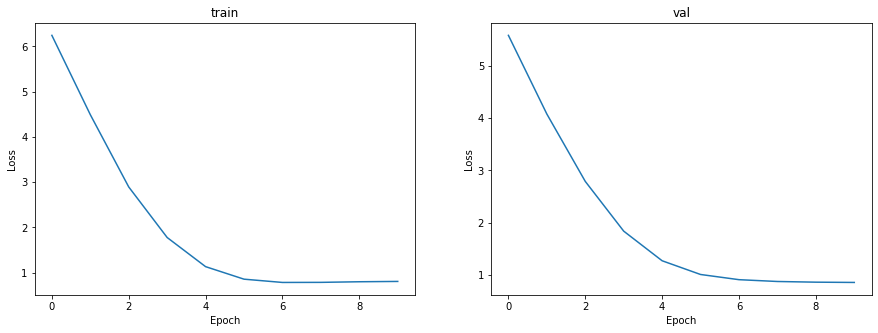

In [11]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

## Interpret the Embeddings

In [13]:
# Extract the learned item bias values
movie_bias = model.item_bias.weight.data
movie_bias = movie_bias.detach().cpu().numpy().squeeze()

# Sort from largest to smallest
idxs = movie_bias.argsort()[::-1][:5]
print(idxs)

# Get the movies corresponding to the largest bias values
#top_rated = [X_train.iloc[i]['movieId'] for i in idxs]
top_rated = trainset.classes
print(top_rated)
movie_titles = pd.read_csv(os.path.join(datapath,'movies.csv'))
top_rated_titles = [movie_titles.loc[movie_titles['movieId']==i]['title'].values[0] for i in top_rated]
top_rated_titles


[ 318 2959  296   50  356]


AttributeError: 

In [14]:
trainset